In [1]:
import numpy as np
from Bio import SeqIO
import gzip
import concurrent.futures
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
qual_0 = "%%%'(-+%%%%%++/1BDEDEEDCCFC79<565448''''''%%$&((&&'&&*448;=@@@AAAA9<?>?EEESHGGIEEEISKHSGS?<<<4=3/,*)&&&%&'(*,,,'%%%%&',+*+*&$%%%%*+*+-)**'(4322/(1201,,676611//))))((((GSIJMDSLFHS:::9<GSSSGSEJIHEIEOKLISHSMGSGKNSHSFHRFHGKEJHSFHHG@>;;;;1:AAAA99:9:?DGAA@66656>=HECCCHSFECDIGF>;331210,)'$$$$%&.:=D<<888JIDFFDD955436765666AFEFA@@@D>@KJNELHHLFJFLF@<///('(()<;=CDHD=:4444485422336222&&''((''(.//3???CAABBCHH@>>>A744.''''(13301132../-**++=>@;:::>E9;:;>AA<<<?B89889>(((')+(''')0*&&&%%&&'''((('((''11&&&&'&&)('&&&'/3/0AEKGKIJGHSHDI@???@EFJFSSIFGISSKSJSCDCIHLKJSHBBAA???==?=?=@<;:8+((DHABBSMEGSGHGBCBBCFKFGDDECEEHDC@ABCBCNKFJGIOSFHQHSGGMS:7767D=;::;:>AA@ACNK=====FH:1112??CCDRECB<111116776.----82----0/-)))*1413,)))*-3---,,111?9999:B<B<=0//&&&(,+&%$$%%()*&&%%&**0132272///.0-(()32224;::9;?ACH@????IJMJSFJSSGDBD??@@@GGBDBBC@>?444))))*?>>@??BBBACJKKSFPJC>>>CAMSJFHKIJHJEDD33336===@8AEBAF00001<=::<<+,512311100*&%%$$%%"

# Add plus 9 ascII value to get phred 42

def coonvert_to_phred42(qual):
    return ''.join([chr(ord(c) + 9) for c in qual])

# Get phred 33 quality score
def get_phred33_quality_score(qual):
    return [ord(c) - 33 for c in qual]

def get_phred42_quality_score(qual):
    return [ord(c) - 42 for c in qual]

qual = add_phred33_quality_score(qual_0)

get_phred42_quality_score(qual) == get_phred33_quality_score(qual_0)

True

In [22]:

score = "#$%%%%''(($$%$*-&%$%)%*'%(+($)(%$,.)##$&$$#$$&('(%&%%%%#$$%(&*('('+18/(6?65510+))'--*&&$$$,*+;/+%%&&''13&%&%(133<;9=/.2*$*657,0*&(237'85;A1/$$%'7:;;:<2:..%$)0,*.)(1)1&&1+-$$,-&(-&&####%%98:AHFEB4(%,"


get_phred33_quality_score(score)

[2,
 3,
 4,
 4,
 4,
 4,
 6,
 6,
 7,
 7,
 3,
 3,
 4,
 3,
 9,
 12,
 5,
 4,
 3,
 4,
 8,
 4,
 9,
 6,
 4,
 7,
 10,
 7,
 3,
 8,
 7,
 4,
 3,
 11,
 13,
 8,
 2,
 2,
 3,
 5,
 3,
 3,
 2,
 3,
 3,
 5,
 7,
 6,
 7,
 4,
 5,
 4,
 4,
 4,
 4,
 2,
 3,
 3,
 4,
 7,
 5,
 9,
 7,
 6,
 7,
 6,
 10,
 16,
 23,
 14,
 7,
 21,
 30,
 21,
 20,
 20,
 16,
 15,
 10,
 8,
 8,
 6,
 12,
 12,
 9,
 5,
 5,
 3,
 3,
 3,
 11,
 9,
 10,
 26,
 14,
 10,
 4,
 4,
 5,
 5,
 6,
 6,
 16,
 18,
 5,
 4,
 5,
 4,
 7,
 16,
 18,
 18,
 27,
 26,
 24,
 28,
 14,
 13,
 17,
 9,
 3,
 9,
 21,
 20,
 22,
 11,
 15,
 9,
 5,
 7,
 17,
 18,
 22,
 6,
 23,
 20,
 26,
 32,
 16,
 14,
 3,
 3,
 4,
 6,
 22,
 25,
 26,
 26,
 25,
 27,
 17,
 25,
 13,
 13,
 4,
 3,
 8,
 15,
 11,
 9,
 13,
 8,
 7,
 16,
 8,
 16,
 5,
 5,
 16,
 10,
 12,
 3,
 3,
 11,
 12,
 5,
 7,
 12,
 5,
 5,
 2,
 2,
 2,
 2,
 4,
 4,
 24,
 23,
 25,
 32,
 39,
 37,
 36,
 33,
 19,
 7,
 4,
 11]

In [2]:
def read_fastq(file_path):
    sequences = []
    
    # Handling gzipped files
    with gzip.open(file_path, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            sequences.append(str(record.seq))
    
    return sequences


def align_and_score(sequence, barcode, end_length):
    """
    Implement your alignment algorithm here. 
    - `sequence`: the protein sequence to be aligned.
    - `barcode`: the barcode sequence to align to the protein sequence.
    - `end_length`: the length of sequence ends to consider for alignment.
    
    You might:
    - Slice the ends of the protein sequence based on `end_length`.
    - Perform alignment with the barcode.
    - Compute and return the alignment score.
    """
    # Example: If considering the end of the sequence
    sequence_end = sequence[-end_length:]
    
    # TODO, alignment score
    
    score = None
    return score

In [3]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo

/home/emre/miniconda3/envs/minion/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [4]:
def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence."""
    complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    complement = [complement_dict[base] for base in seq]
    return ''.join(complement)[::-1]

In [11]:
fastqfiles = glob.glob("/home/emre/minION_results/MinION_RBC_0902723_sup/basecalled_filtered/*")

# Choose randomly 20
fastqfiles = np.random.choice(fastqfiles, 10).tolist()

In [12]:
sequences = read_fastq(fastqfiles[0])

In [20]:
sequences = []

for fastqfile in fastqfiles:
    sequences.extend(read_fastq(fastqfile))

In [22]:
len(sequences)

35276

In [13]:
barcode_dict = {"Reverse": {
            "Barcode01" : "AAGAAAGTTGTCGGTGTCTTTGTG",
            "Barcode02" : "TCGATTCCGTTTGTAGTCGTCTGT",
            "Barcode03" : "GAGTCTTGTGTCCCAGTTACCAGG"
            },
            "Reverse-Complement": {
            "Barcode01" : "CACAAAGACACCGACAACTTTCTT",
            "Barcode02" : "ACAGACGACTACAAACGGAATCGA",
            "Barcode03" : "CCTGGTAACTGGGACACAAGACTC"
            }
}

config = {
    "start_gap1": 40,
    "end_gap1": 40,
    "open_gap1": 0,
    "extend_gap1": -40,
    "start_gap2": 40,
    "end_gap2": 40,
    "open_gap2": -160,
    "extend_gap2": -160,
    "min_score_barcode_front": 60.0,
    "front_window_size": 150,
    "rear_window_size": 150,
}

In [14]:
def scoring_matrix():
    return {
        ('A', 'A'): 96,  ('A', 'C'): -316, ('A', 'G'): -192, ('A', 'T'): -369, ('A', 'N'): 0,
        ('C', 'A'): -316,('C', 'C'): 100,  ('C', 'G'): -352, ('C', 'T'): -295, ('C', 'N'): 0,
        ('G', 'A'): -192,('G', 'C'): -352, ('G', 'G'): 98,   ('G', 'T'): -329, ('G', 'N'): 0,
        ('T', 'A'): -369,('T', 'C'): -295, ('T', 'G'): -329, ('T', 'T'): 100,  ('T', 'N'): 0,
        ('N', 'A'): 0,   ('N', 'C'): 0,    ('N', 'G'): 0,    ('N', 'T'): 0,    ('N', 'N'): 0,
    }

In [15]:
def get_theoretical_max_score(barcode, scoring_matrix):
    # Get the match score for a matching pair of nucleotides
    match_score = 0
    for i in range(len(barcode)):
        if barcode[i] != 'N':
            match_score += scoring_matrix[(barcode[i], barcode[i])]
    
    
    # The theoretical max score is N * match score
    return match_score

def get_best_scored_segment(seq1, seq2, config, complement = False, top_k=3):
    # Only consider the first 100bp of seq2 for alignment

    if complement:
        seq1 = seq1[-100:] #Get rear 100bp of seq1

    seq1 = seq1[:100]
    sm = scoring_matrix()
    # Perform local alignment using Smith-Waterman algorithm
    alignments = pairwise2.align.localds(seq1, seq2, sm, -40, -40)
    # Get top-k alignments
    top_alignments = alignments[:top_k]
    
    best_score = 0
    best_alignment = None
    
    for alignment in top_alignments:
        # Unpack alignment data
        aligned_seq1, aligned_seq2, score, begin, end = alignment
        
        # Recalculate score from 'begin' to 'end'
        segment_score = 0
        for i in range(begin, end):

            # Use the scoring matrix to calculate the score
            segment_score += sm.get((aligned_seq1[i], aligned_seq2[i]), 0)
        
        # Update if the score of this segment is the best so far
        if segment_score > best_score:
            best_score = segment_score
            best_alignment = alignment
    
    # Return the best-scoring alignment segment
    return best_alignment


In [16]:
def demultiplex_template(args):
    i, sequence, barcode_dict, sm, config = args

    barcodes = barcode_dict["Reverse"]
    
    result = {"Sequence_ind": i,
              "Barcode_Scores": {},
              "Best_Barcode" : {"RBC": None, "Score": None}}

    barcode_scores = np.zeros(len(barcodes))

    for barcode_name, barcode_seq in barcodes.items():
        theoretical_max_score = get_theoretical_max_score(barcode_seq, sm)
        alignment = get_best_scored_segment(sequence, barcode_seq, config)

        if alignment:
            aligned_seq1, aligned_seq2, score, begin, end = alignment
            norm_score = (score / theoretical_max_score) * 100
            
            result["Barcode_Scores"][barcode_name] = norm_score
            
        else:
            result["Barcode_Scores"][barcode_name] = 0

        barcode_scores[list(barcodes.keys()).index(barcode_name)] = norm_score
    
    if barcode_scores.max() > config["min_score_barcode_front"]:
        result["Best_Barcode"]["RBC"] = list(barcodes.keys())[np.argmax(barcode_scores)]
        result["Best_Barcode"]["Score"] = np.max(barcode_scores)
    else:
        result["Best_Barcode"]["RBC"] = "Unclassified"
        result["Best_Barcode"]["Score"] = np.max(barcode_scores)
    
    return result

def demultiplex_complement(args):
    i, sequence, barcode_dict, sm, config = args

    barcodes = barcode_dict["Reverse-Complement"]

    result = {"Sequence_ind": i,
              "Barcode_Scores": {},
              "Best_Barcode" : {"RBC": None, "Score": None}}

    barcode_scores = np.zeros(len(barcodes))

    for barcode_name, barcode_seq in barcodes.items():
        theoretical_max_score = get_theoretical_max_score(barcode_seq, sm)
        alignment = get_best_scored_segment(sequence, barcode_seq,config, complement = True)

        if alignment:
            aligned_seq1, aligned_seq2, score, begin, end = alignment
            norm_score = (score / theoretical_max_score) * 100
            
            result["Barcode_Scores"][barcode_name] = norm_score
            
        else:
            result["Barcode_Scores"][barcode_name] = 0

        barcode_scores[list(barcodes.keys()).index(barcode_name)] = norm_score
    
    if barcode_scores.max() > config["min_score_barcode_front"]:
        result["Best_Barcode"]["RBC"] = list(barcodes.keys())[np.argmax(barcode_scores)]
        result["Best_Barcode"]["Score"] = np.max(barcode_scores)
    else:
        result["Best_Barcode"]["RBC"] = "Unclassified"
        result["Best_Barcode"]["Score"] = np.max(barcode_scores)
    
    return result


def demultiplex_sequence(args):
    i, sequence, barcode_dict, sm, config = args
    
    # First, try to demultiplex using the template strand
    result_template = demultiplex_template(args)
    
    # If the best barcode from the template strand is not "Unclassified", return the result
    if result_template["Best_Barcode"]["RBC"] != "Unclassified":
        return result_template
    
    # Otherwise, try to demultiplex using the complement
    result_complement = demultiplex_complement(args)
    
    # Return the result from the complement strand, regardless of whether it is "Unclassified" or not
    return result_complement



In [23]:
def process_file(file):
    sm = scoring_matrix()
    final_scores = {"Sequence_ind": [], 
                    "Barcode_Scores" : {"Barcode01" : [], "Barcode02" : [], "Barcode03" : []},
                    "Best_Barcode" : {"RBC": [], "Score": []},
                    }
    
    sequences = read_fastq(file)
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as per your system
        args = [(i, seq, barcode_dict, sm, config) for i, seq in enumerate(sequences)]
        results = list(executor.map(demultiplex_sequence, args))
    
    for result in results:
        final_scores["Sequence_ind"].append(result["Sequence_ind"])
        for barcode_name, score in result["Barcode_Scores"].items():
            final_scores["Barcode_Scores"][barcode_name].append(score)
        final_scores["Best_Barcode"]["RBC"].append(result["Best_Barcode"]["RBC"])
        final_scores["Best_Barcode"]["Score"].append(result["Best_Barcode"]["Score"])
    
    return final_scores

def process_sequences(sequences):
    sm = scoring_matrix()
    final_scores = {"Sequence_ind": [], 
                    "Barcode_Scores" : {"Barcode01" : [], "Barcode02" : [], "Barcode03" : []},
                    "Best_Barcode" : {"RBC": [], "Score": []},
                    }
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as per your system
        args = [(i, seq, barcode_dict, sm, config) for i, seq in enumerate(sequences)]
        results = list(executor.map(demultiplex_sequence, args))
    
    for result in results:
        final_scores["Sequence_ind"].append(result["Sequence_ind"])
        for barcode_name, score in result["Barcode_Scores"].items():
            final_scores["Barcode_Scores"][barcode_name].append(score)
        final_scores["Best_Barcode"]["RBC"].append(result["Best_Barcode"]["RBC"])
        final_scores["Best_Barcode"]["Score"].append(result["Best_Barcode"]["Score"])
    
    return final_scores



In [4]:
import hashlib

def generate_sha1_hash(input_string):
    sha1 = hashlib.sha1()
    sha1.update(input_string.encode('utf-8'))
    return sha1.hexdigest()

# Example usage:
input_string = "ExampleString"
hash_output = generate_sha1_hash(input_string)

print(f"Input: {input_string}")
print(f"SHA-1 Hash: {hash_output}")

Input: ExampleString
SHA-1 Hash: c223c69401a5ad7acf29e84c130eced80e71e6c4


In [19]:
final_score  = process_sequences(sequences)

In [22]:
# Barcode score dist
import pandas as pd

file = "/home/emre/tutorials/sequence_tut/source/alignment_results.txt"

df = pd.read_csv(file, sep="\t")

In [23]:
df

,Best_Barcode,Score
0,Barcode03-Rev,100.0000
1,Barcode02,64.0336
2,Barcode01,100.0000
3,Barcode02,79.9160
4,unclassified,32.8814
...,...,...
17679,Barcode01,100.0000
17680,Barcode01-Rev,50.9322
17681,Barcode03-Rev,85.5932
17682,Barcode02-Rev,87.6385


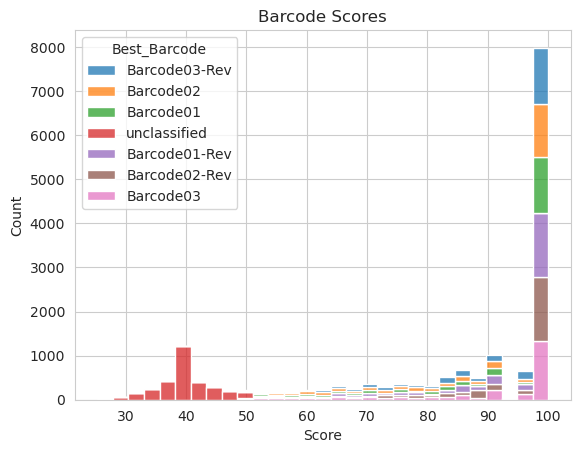

In [24]:
import pandas as pd
#pd.DataFrame(final_scores["Best_Barcode"])

#Change type of the scores
df["Score"] = df["Score"].astype(float)

# Plotting the scores
sns.set_style("whitegrid")
sns.histplot(data=df, x="Score", hue="Best_Barcode", multiple="stack", kde=False)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Barcode Scores")
plt.show()

In [82]:
def get_best_scored_segment_global(seq1, seq2, config, top_k=5):
    # Perform global alignment using Needleman-Wunsch algorithm
    sm = scoring_matrix()
    alignments = pairwise2.align.globalds(seq1, seq2, sm, 
                                          config["open_gap1"], 
                                          config["extend_gap1"])
    
    # Get top-k alignments
    top_alignments = alignments[:top_k]

    best_score = 0
    best_alignment = None
    
  
    
    for alignment in top_alignments:
        # Unpack alignment data
        aligned_seq1, aligned_seq2, score, begin, end = alignment
        
        # Recalculate score for the entire aligned segment
        segment_score = 0
        for i in range(len(aligned_seq1)):
            # Use the scoring matrix to calculate the score
            segment_score += sm.get((aligned_seq1[i], aligned_seq2[i]), 0)
        
        # Update if the score of this segment is the best so far
        if segment_score > best_score:
            best_score = segment_score
            best_alignment = alignment
    
    # Return the best-scoring alignment segment
    return best_alignment


for barcode_name, barcode_seq in barcodes.items():
    alignment = get_best_scored_segment_global(sequence, barcode_seq, config)
    
    if alignment:
        aligned_seq1, aligned_seq2, score, begin, end = alignment
        print("Aligned Sequences:")
        print(aligned_seq1)
        print(aligned_seq2)
        print("Alignment Score:", score)
        print("Alignment starts at position", begin, "and ends at position", end)


Aligned Sequences:
TGTGTGCATGTACTCGTTCAGTTACGTATTGCTGGACGAAGAACTCAAGTCAAAGGCATCTCAATCCCGCGAAATTAATACGACTCACTATAGGGGAATTGTCAGCGGATAACAATTCCCCTCTAAATAATTTTGTTTAACTTT
-----------------------A---A------GA--AAG---T----T-----G--------T--CG-G-------T--G--T--C----------TT-T-----G-------------------------TG---------
Alignment Score: -2436.0
Alignment starts at position 0 and ends at position 144
Aligned Sequences:
TGTGTGCATGTACTCGTTCAGTTACGTATTGCTGGACGAAGAACTCAAGTCAAAGGCATCTCAATCCCGCGAAATTAATACGACTCACTATAGGGGAATTGTCAGCGGATAACAATTCCCCTCTAAATAATTTTGTTTAACTTT
-------------------------------------------------TC----G-A--T---T--C-CG---TT--T--G--------T------A--GT---C-G-------------TC----------TG--------T
Alignment Score: -2420.0
Alignment starts at position 0 and ends at position 144
Aligned Sequences:
TGTGTGCATGTACTCGTTCAGTTACGTATTGCTGGACGAAGAACTCAAGTCAAAGGCATCTCAATCCCGCGAAATTAATACGACTCACTATAGGGGAATTGTCAGCGGATAACAATTCCCCTCTAAATAATTTTGTTTAACTTT
---------------G---AG-T-C----T--T-------G---T---GT------

In [53]:
config

{'start_gap1': 40,
 'end_gap1': 40,
 'open_gap1': 40,
 'extend_gap1': 40,
 'start_gap2': 40,
 'end_gap2': 40,
 'open_gap2': 160,
 'extend_gap2': 160,
 'min_score_barcode_front': 60.0,
 'front_window_size': 150,
 'rear_window_size': 150}